In [1]:
import os
os.environ["ROS_MASTER_URI"]="http://fetch48.local:11311"
# os.environ["OPENAI_API_KEY"] = ""


In [2]:
%load_ext autoreload
%matplotlib inline
from IPython.display import display

In [3]:
# python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
sys.path.append("../../")
import os

from utils.logging import CustomLogger
from utils import logging
from agents import agent_factory

from executor import SimpleExecutor, LineWiseExecutor

from utils.image_utils import visualize_image, resize_image


In [4]:
logger = CustomLogger()
logging.set_logger(logger)

In [5]:
from environments.real_world import RealWorldEnv
env = RealWorldEnv()
env.setup()

In [6]:
def run_experiment(env, agent, prompt, debug=True):
    print("Image before planning: ")
    image = env.get_image()
    visualize_image(image)
    plan_result = agent.try_plan(prompt, image)
    print(plan_result)
    
    if not plan_result.success:
        return
        
    print("Annotated image: ")
    visualize_image(plan_result.annotated_image)
    # Build a context containing the masks for the plan code to access
    masks = {"regions": [mask["segmentation"] for mask in plan_result.masks]}

    # Fake execution for inspection
    global inspect_logger
    context, inspect_logger = env.get_inspect_execution_context(plan_image=image)
    inspect_executor = SimpleExecutor(context)
    inspect_executor.execute_plan(plan_result.plan_code, additional_context=masks)
    print("-" * 50)
    print("A visualization of the plan to execute:")
    display(inspect_logger.display_html_logs_in_notebook())
    print("-" * 50)

    if input("Continue to execute in the real world?") != 'y':
        print("Execution terminated by user.")
        return

    # Real execution
    executor = LineWiseExecutor(env.get_execution_context(), pause_every_line=True)
    executor.execute_plan(plan_result.plan_code, additional_context=masks)

    print("After manipulation: ")
    visualize_image(env.get_image())

    return plan_result

Specify Your task here.

In [7]:
prompt="""Task: Put the red block into the green bowl."""
prompt="""Task: Put the black remote on the keyboard."""

In [8]:
# processed_image = resize_image(image, 640])

Image before planning: 


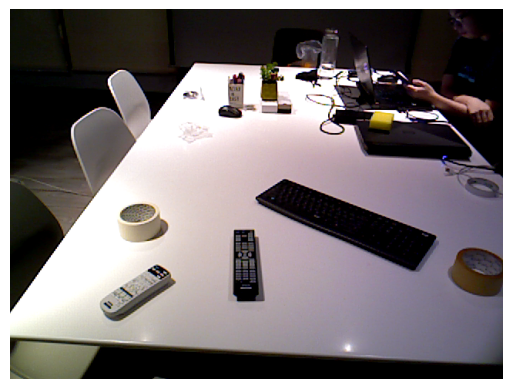

KeyError: 'OPENAI_API_KEY'

In [8]:
agent = agent_factory("VLMDetInspect")
# agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)


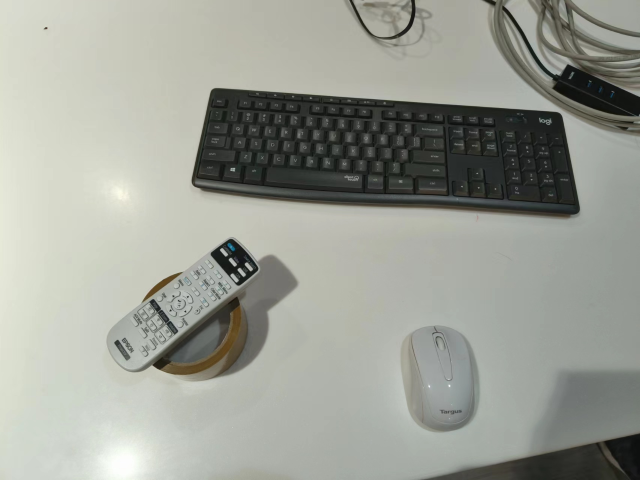
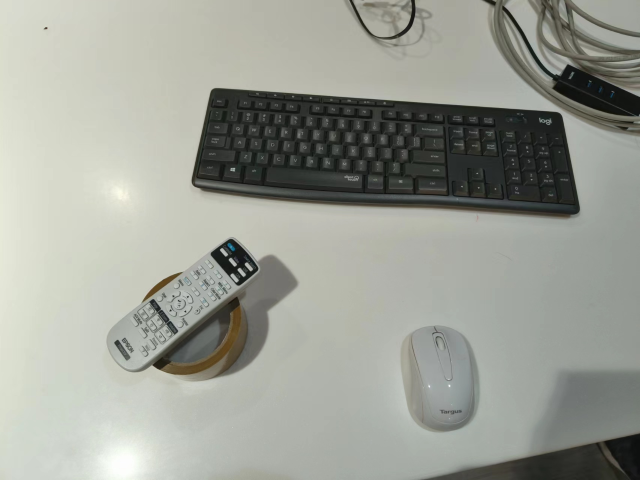
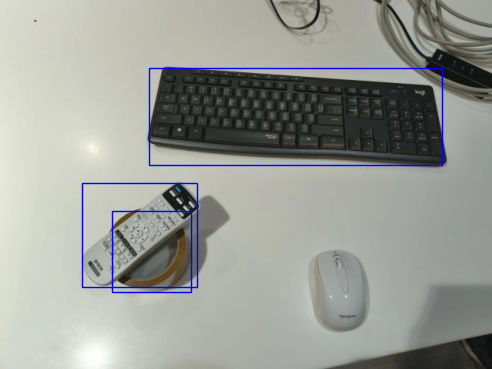
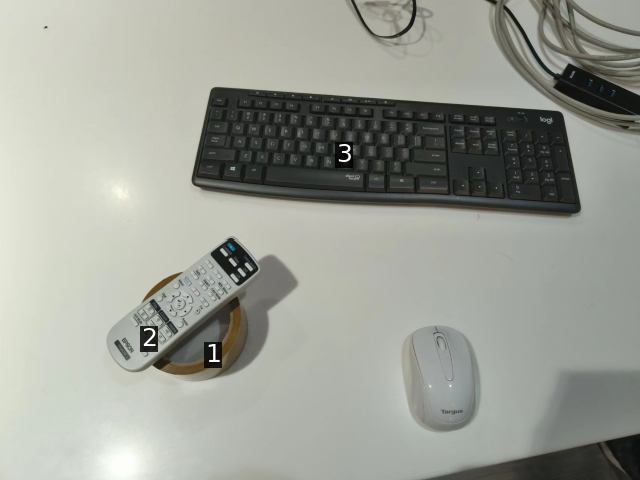
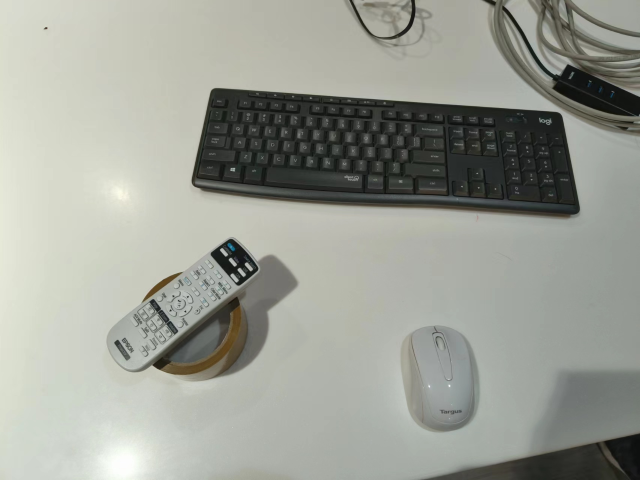

In [ ]:
logging.get_logger().display_html_logs_in_notebook()

In [ ]:
logger.save_logs_to_html_file("result.html")